0      POINT (2685557 1246207)
1      POINT (2686135 1246125)
2      POINT (2686254 1251205)
3      POINT (2686608 1248635)
4      POINT (2687579 1245780)
                ...           
462    POINT (2683170 1253823)
463    POINT (2683302 1247991)
464    POINT (2683333 1247286)
465    POINT (2683401 1247353)
466    POINT (2683401 1247599)
Name: geometry, Length: 467, dtype: object


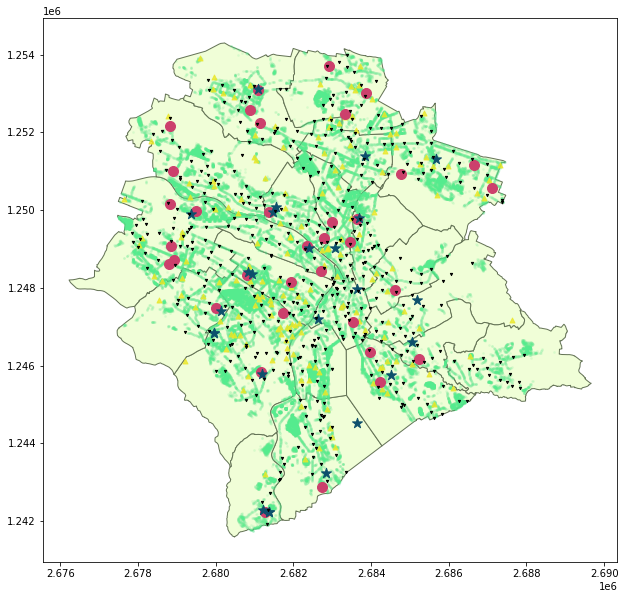

In [6]:
####################################
### Care home locations in Zurich ###
####################################

# Authors: R. Johannessen, S. Santschi, R. ???
# Contact: rjohannessen@live.no 
# Last updated: 30.06.2021
# Description: Overview map of care homes in Zurich and facilities found nearby

###########
# Imports #
###########

# Read csv and create static map with pandas
import pandas as pd
import geopandas

# Interactive map imports -> Bokeh
import bokeh
import json
from bokeh.io import show
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure

# Save plots
import matplotlib.pyplot as plt

#############
# Load data #
#############

# Care home data
gdf = geopandas.read_file('data/alterswohnung_und_alterszentrum.csv', GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO", encoding='utf-8')

## Seperate apartments from dataset
gdf_apartments = gdf['da']=='Alterswohnung'
apartments = gdf[gdf_apartments]

## Seperate care centres from dataset
gdf_centres = gdf['da']=='Alterszentren'
centres = gdf[gdf_centres]

# Load trees
path_to_data = 'data/Baumstandort.csv'
trees = geopandas.read_file(path_to_data, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO", encoding='utf-8')

# Load playgrounds
path_to_data = 'data/Spielplatz.csv'
playgrounds = geopandas.read_file(path_to_data, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO", encoding='utf-8')

# Load stations
df = pd.read_csv('data/ZVV_HALTESTELLEN_P.csv')
df.head()

## Format point data for stations
df['geometry'] = 'POINT (' + df['E'].astype(str) + ' ' + df['N'].astype(str) + ')'
print(df['geometry'])

## Save point data to CSV
df.to_csv('data/stations.csv')

## Load stations with point data
path_to_data = 'data/stations.csv'
stations = geopandas.read_file(path_to_data, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO", encoding='utf-8')

# Load base map
ch = geopandas.read_file('data/stzh.adm_verwaltungsquartiere_a.shp')
base = ch.plot(color='#F0FED7', edgecolor='#647356', figsize = (15, 10))

# Plot point data on base map
trees.plot(ax=base, color = '#55EB8E', alpha = 0.1, markersize=3)
playgrounds.plot(ax=base, marker = '^', color = '#EBE728', alpha = 0.8, markersize=25)
apartments.plot(ax=base, marker = 'o', color = '#CC406C', markersize=100, legend = "True")
centres.plot(ax=base, marker = '*', color = '#0D506C', markersize=110, legend = "True")
stations.plot(ax=base, marker = 'v', color = '#000000', markersize=5, legend = "True")


plt.savefig('altersheime.jpg')


# Input GeoJSON source that contains features for plotting
geosource = GeoJSONDataSource(geojson = ch.to_json())
apartmentsource = GeoJSONDataSource(geojson = apartments.to_json())
centresource = GeoJSONDataSource(geojson = centres.to_json())
treesource = GeoJSONDataSource(geojson = trees.to_json())
playsource = GeoJSONDataSource(geojson = playgrounds.to_json())
stationsource = GeoJSONDataSource(geojson = stations.to_json())

json.dumps(apartments.to_json())


p = figure(title = 'Altersheime in Zürich', 
           plot_height = 600 ,
           plot_width = 950, 
           toolbar_location = 'below',
           tools = 'pan, wheel_zoom, box_zoom, reset')
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.
states = p.patches('xs','ys', source = geosource,
                   fill_color = '#D5F0F2',
                   line_color = '#647356', 
                   line_width = 0.5, 
                   fill_alpha = 1)

# Plot data onto base map
plot_trees = p.circle(source = treesource, color = '#6FF76F', 
                 size = 2, alpha = 0.1)
plot_playgrounds = p.circle(source = playsource, color = '#E975EB', 
                 size = 4, alpha = 1)
plot_stations = p.star(source = stationsource, color = '#F5B165', 
                 size = 8, alpha = 0.8)
plot_apartments = p.circle(source = apartmentsource, color = '#CC406C', 
                 size = 10, alpha = 1)
plot_centres = p.circle(source = centresource, color = '#0D506C', 
                 size = 10, alpha = 1)

# Add hover tool
p.add_tools(HoverTool(renderers = [plot_apartments, plot_centres, plot_stations],
                      tooltips = [('Name', '@name'),
                                  ('Typ', '@da'),
                                  ],
                        formatters ={
                            '@name' : 'printf',
                        })
                                  )
# plot, and add it to the current document
layout = column(p)
show(layout)